In [28]:
import torch
import torchvision.transforms as transforms
from dataset import TestDataset
from model import CNNtoRNN
import matplotlib.pyplot as plt  
from nltk.translate.bleu_score import corpus_bleu

IMAGES_PATH = './flickr8/Images'
CAPTIONS_PATH = './flickr8/captions.txt'

In [2]:
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)

In [3]:
test_dataset = TestDataset(CAPTIONS_PATH, IMAGES_PATH, transform=transforms.Compose(
        [
            transforms.Resize(256),
            transforms.CenterCrop(224),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
        ]
    ))

In [4]:
model = CNNtoRNN(embed_size=256, hidden_size=256, vocab_size=len(test_dataset.caption_vocab), num_layers=1).to(device)


In [6]:
checkpoint = torch.load('./model.pt')
model.load_state_dict(checkpoint['model_state_dict'])
model.eval()

CNNtoRNN(
  (encoder): EncoderCNN(
    (cnn): ResNet(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (conv2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
          (bn2): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (conv3): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (rel

In [19]:
vocab = test_dataset.caption_vocab.to(device)
results = []

for idx, (img_label, img, caption) in enumerate(test_dataset):
    sample_img = img.to(device)
    sample_img_label = img_label
    sample_img_caption = caption
    generated_caption = model.caption_image(sample_img, vocab)
    result = {
        'img_label': img_label,
        'img': img.T,
        'target_caption': [vocab.lookup_token(token) for token in caption],
        'generated_caption': generated_caption
    }
    results.append(result)


/var/folders/6z/lhgv6xpn3qz3b3qkbr2glhrm0000gq/T/ipykernel_36104/3745061719.py:11: UserWarning: The use of `x.T` on tensors of dimension other than 2 to reverse their shape is deprecated and it will throw an error in a future release. Consider `x.mT` to transpose batches of matrices or `x.permute(*torch.arange(x.ndim - 1, -1, -1))` to reverse the dimensions of a tensor. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/aten/src/ATen/native/TensorShape.cpp:3679.)
  'img': img.T,


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


./flickr8/Images/1000268201_693b08cb0e.jpg
['<bos>', 'A', 'little', 'girl', 'in', 'a', 'pink', 'dress', 'going', 'into', 'a', 'wooden', 'cabin', '.', '\n', '<eos>']
['<bos>', 'A', 'little', 'girl', 'in', 'a', 'pink', 'shirt', 'is', 'standing', 'on', 'a', 'sidewalk', '.', '\n', '<eos>']


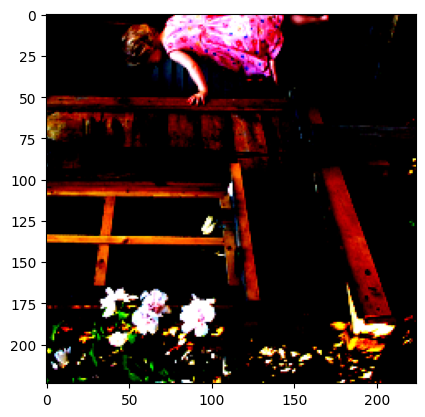

In [24]:
plt.imshow(results[0]['img'])
print(results[0]['img_label'])
print(results[0]['target_caption'])
print(results[0]['generated_caption'])


In [55]:
sum_bleu_scores = 0
number_samples = 0
for result in results:
    number_samples += 1
    references = [[result['target_caption']]]
    candidates = [result['generated_caption']]
    sum_bleu_scores += corpus_bleu(references, candidates)

In [56]:
avg_bleu_score = sum_bleu_scores / number_samples
print(avg_bleu_score)

0.46892438882117243
